# 1 GAN

In [1]:
import os, sys

# Add DLStudio-2.5.2 and AdversarialLearning to sys.path so Python can find DLStudio and AdversarialLearning
current_dir = os.getcwd()
print("current_dir = %s" % current_dir)

DLStudio_dir = os.path.join(current_dir, "../DLStudio-2.5.2")

sys.path.append(DLStudio_dir)

from DLStudio import *


current_dir = d:\MS Purdue\1.5\ECE60146\HW9


### 1.1 Model

In [8]:
# the code below is mainly borrowed from DLSudio-2.5.2

from DLStudio import DLStudio

import sys,os,os.path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision                  
import torchvision.transforms as tvt
import torchvision.transforms.functional as tvtF
import torch.optim as optim
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import glob                                                                                                           
import imageio                                                                                                        

#______________________________  AdversarialLearning Class Definition  ________________________________

class MyAdversarialLearning(object):

    def __init__(self, *args, **kwargs ):
        if args:
            raise ValueError(  
                   '''AdversarialLearning constructor can only be called with keyword arguments for the following
                      keywords: epochs, learning_rate, batch_size, momentum, image_size, dataroot, path_saved_model, 
                      use_gpu, latent_vector_size, ngpu, dlstudio, device, LAMBDA, clipping_threshold, and beta1''')
        allowed_keys = 'dataroot','image_size','path_saved_model','momentum','learning_rate','epochs','batch_size', \
                       'classes','use_gpu','latent_vector_size','ngpu','dlstudio', 'beta1', 'LAMBDA', 'clipping_threshold'
        keywords_used = kwargs.keys()                                                                 
        for keyword in keywords_used:                                                                 
            if keyword not in allowed_keys:                                                           
                raise SyntaxError(keyword + ":  Wrong keyword used --- check spelling")  
        learning_rate = epochs = batch_size = convo_layers_config = momentum = None
        image_size = fc_layers_config = dataroot =  path_saved_model = classes = use_gpu = None
        latent_vector_size = ngpu = beta1 = LAMBDA = clipping_threshold = None
        if 'latent_vector_size' in kwargs            :   latent_vector_size = kwargs.pop('latent_vector_size')
        if 'ngpu' in kwargs                          :   ngpu  = kwargs.pop('ngpu')           
        if 'dlstudio' in kwargs                      :   dlstudio  = kwargs.pop('dlstudio')
        if 'beta1' in kwargs                         :   beta1  = kwargs.pop('beta1')
        if 'LAMBDA' in kwargs                        :   LAMBDA  = kwargs.pop('LAMBDA')
        if 'clipping_threshold' in kwargs            :   clipping_threshold = kwargs.pop('clipping_threshold')
        if latent_vector_size:
            self.latent_vector_size = latent_vector_size
        if ngpu:
            self.ngpu = ngpu
        if dlstudio:
            self.dlstudio = dlstudio
        if beta1:
            self.beta1 = beta1
        if LAMBDA:
            self.LAMBDA = LAMBDA
        if clipping_threshold:
            self.clipping_threshold = clipping_threshold 



    def show_sample_images_from_dataset(self, dlstudio):
        data = next(iter(self.train_dataloader))    
        real_batch = data[0]
        self.dlstudio.display_tensor_as_image(torchvision.utils.make_grid(real_batch, padding=2, pad_value=1, normalize=True))


    def set_dataloader(self):
        dataset = torchvision.datasets.ImageFolder(root=self.dlstudio.dataroot,       
                       transform = tvt.Compose([                 
                                            tvt.Resize(self.dlstudio.image_size),             
                                            tvt.CenterCrop(self.dlstudio.image_size),         
                                            tvt.ToTensor(),                     
                                            tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),         
                       ]))
        self.train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.dlstudio.batch_size, 
                                                                                 shuffle=True, num_workers=2)

    def weights_init(self,m):        
        """
        Uses the DCGAN initializations for the weights
        """
        classname = m.__class__.__name__     
        if classname.find('Conv') != -1:         
            nn.init.normal_(m.weight.data, 0.0, 0.02)      
        elif classname.find('BatchNorm') != -1:         
            nn.init.normal_(m.weight.data, 1.0, 0.02)       
            nn.init.constant_(m.bias.data, 0)      


    def calc_gradient_penalty(self, netC, real_data, fake_data):
        """
        Implementation by Marvin Cao: https://github.com/caogang/wgan-gp
        Marvin Cao's code is a PyTorch version of the Tensorflow based implementation provided by
        the authors of the paper "Improved Training of Wasserstein GANs" by Gulrajani, Ahmed, 
        Arjovsky, Dumouli,  and Courville.
        """
        BATCH_SIZE = self.dlstudio.batch_size
        LAMBDA = self.LAMBDA
        epsilon = torch.rand(1).cuda()
        interpolates = epsilon * real_data + ((1 - epsilon) * fake_data)
        interpolates = interpolates.requires_grad_(True).cuda() 
        critic_interpolates = netC(interpolates)
        gradients = torch.autograd.grad(outputs=critic_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(critic_interpolates.size()).cuda(), 
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
        return gradient_penalty
    

    def close_event(self):   
        '''
        from stackoverflow.com
        '''
        plt.close()


    class SkipBlockDN(nn.Module):
        """
        This is a building-block class for constructing the Critic Network for adversarial learning.  In
        general, such a building-bloc class would be used for designing a network that creates a
        resolution hierarchy for the input image in which each successive layer is a downsampled version
        of the input image with or without increasing the number of input channels.

        Class Path:  AdversarialLearning  ->  SkipBlockDN
        """
        def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
            super(MyAdversarialLearning.SkipBlockDN, self).__init__()
            self.downsample = downsample
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convo1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1)
            self.convo2 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(out_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            self.downsampler1 = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=2)
            self.downsampler2 = nn.Conv2d(out_ch, out_ch, kernel_size=1, stride=2)
        def forward(self, x):
            identity = x                                     
            out = self.convo1(x)                              
            out = self.bn1(out)                              
            out = torch.nn.functional.relu(out)
            if self.in_ch == self.out_ch:
                out = self.convo2(out)                              
                out = self.bn2(out)                              
                out = torch.nn.functional.leaky_relu(out, negative_slope=0.2)
            if self.downsample:
                out = self.downsampler2(out)
                identity = self.downsampler1(identity)
            if self.skip_connections:
                out += identity                              
            return out

    class SkipBlockUP(nn.Module):
        """
        This is also a building-block class meant for a CNN that requires upsampling the images at the 
        inputs to the successive layers.  I could use it in the Generator part of an Adversarial Network,
        but have not yet done so.

        Class Path:  AdversarialLearning  ->  SkipBlockUP
        """
        def __init__(self, in_ch, out_ch, upsample=False, skip_connections=True):
            super(MyAdversarialLearning.SkipBlockUP, self).__init__()
            self.upsample = upsample
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convoT1 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
            self.convoT2 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
            self.bn1 = nn.BatchNorm2d(out_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            if upsample:
                self.upsampler = nn.ConvTranspose2d(in_ch, out_ch, 1, stride=2, dilation=2, output_padding=1, padding=0)
        def forward(self, x):
            identity = x                                     
            out = self.convoT1(x)                              
            out = self.bn1(out)                              
            out = torch.nn.functional.relu(out)
            if self.in_ch == self.out_ch:
                out = self.convoT2(out)                              
                out = self.bn2(out)                              
                out = torch.nn.functional.leaky_relu(out, negative_slope=0.2)
            if self.upsample:
                out = self.upsampler(out)
                out = torch.nn.functional.leaky_relu(out, negative_slope=0.2)           
                identity = self.upsampler(identity)
                identity = torch.nn.functional.leaky_relu(identity, negative_slope=0.2) 
            if self.skip_connections:
                if self.in_ch == self.out_ch:
                    out += identity                              
                else:
                    out += identity[:,self.out_ch:,:,:]
                out = torch.nn.functional.leaky_relu(out, negative_slope=0.2)           
            return out


    class DiscriminatorDG2(nn.Module):
        """
        This is essentially the same network as the DCGAN for DG1, except for the extra layer
        "self.extra" shown below.  We also declare a batchnorm for this extra layer in the form
        of "self.bnX".  In the implementation of "forward()", we invoke the extra layer at the
        beginning of the network.

        Class Path:  AdversarialLearning  ->   DiscriminatorDG2
        """            
        def __init__(self, skip_connections=True, depth=16):
            super(MyAdversarialLearning.DiscriminatorDG2, self).__init__()
            self.conv_in = nn.Conv2d(  3,    64,      kernel_size=4,      stride=2,    padding=1)
            self.extra =   nn.Conv2d(  64,    64,      kernel_size=4,      stride=1,    padding=2)
            self.conv_in2 = nn.Conv2d( 64,   128,     kernel_size=4,      stride=2,    padding=1)
            self.conv_in3 = nn.Conv2d( 128,  256,     kernel_size=4,      stride=2,    padding=1)
            self.conv_in4 = nn.Conv2d( 256,  512,     kernel_size=4,      stride=2,    padding=1)
            self.conv_in5 = nn.Conv2d( 512,  1,       kernel_size=4,      stride=1,    padding=0)
            self.bn1  = nn.BatchNorm2d(128)
            self.bn2  = nn.BatchNorm2d(256)
            self.bn3  = nn.BatchNorm2d(512)
            self.bnX  = nn.BatchNorm2d(64)
            self.sig = nn.Sigmoid()
        def forward(self, x):       
            x = torch.nn.functional.leaky_relu(self.conv_in(x), negative_slope=0.2, inplace=True)
            x = self.bnX(self.extra(x))
            x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
            x = self.bn1(self.conv_in2(x))
            x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
            x = self.bn2(self.conv_in3(x))
            x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
            x = self.bn3(self.conv_in4(x))
            x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
            x = self.conv_in5(x)
            x = self.sig(x)
            return x

    class GeneratorDG2(nn.Module):
        """
        The Generator for DG2 is exactly the same as for the DG1.  So please the comment block for that
        Generator.

        Class Path:  AdversarialLearning  ->   GeneratorDG2
        """
        def __init__(self):
            super(MyAdversarialLearning.GeneratorDG2, self).__init__()
            self.latent_to_image = nn.ConvTranspose2d( 100,   512,  kernel_size=4, stride=1, padding=0, bias=False)
            self.upsampler2 = nn.ConvTranspose2d( 512, 256, kernel_size=4, stride=2, padding=1, bias=False)
            self.upsampler3 = nn.ConvTranspose2d (256, 128, kernel_size=4, stride=2, padding=1, bias=False)
            self.upsampler4 = nn.ConvTranspose2d (128, 64,  kernel_size=4, stride=2, padding=1, bias=False)
            self.upsampler5 = nn.ConvTranspose2d(  64,  3,  kernel_size=4, stride=2, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(512)
            self.bn2 = nn.BatchNorm2d(256)
            self.bn3 = nn.BatchNorm2d(128)
            self.bn4 = nn.BatchNorm2d(64)
            self.tanh  = nn.Tanh()
        def forward(self, x):                             
            x = self.latent_to_image(x)
            x = torch.nn.functional.relu(self.bn1(x))
            x = self.upsampler2(x)
            x = torch.nn.functional.relu(self.bn2(x))
            x = self.upsampler3(x)
            x = torch.nn.functional.relu(self.bn3(x))
            x = self.upsampler4(x)
            x = torch.nn.functional.relu(self.bn4(x))
            x = self.upsampler5(x)
            x = self.tanh(x)
            return x
    ########################################   DG2 Definition ENDS   ###########################################



    ############################################################################################################
    ##  The training routines follow, first for a GAN constructed using either the DG1 and or the DG2 
    ##  Discriminator-Generator Networks, and then for a WGAN constructed using either the CG1 or the CG2
    ##  Critic-Generator Networks.
    ############################################################################################################

    def run_gan_code(self, dlstudio, discriminator, generator, results_dir):
        """
        This function is meant for training a Discriminator-Generator based Adversarial Network.  
        The implementation shown uses several programming constructs from the "official" DCGAN 
        implementations at the PyTorch website and at GitHub. 

        Regarding how to set the parameters of this method, see the following script

                     dcgan_DG1.py

        in the "ExamplesAdversarialLearning" directory of the distribution.
        """
        dir_name_for_results = results_dir
        if os.path.exists(dir_name_for_results):
            files = glob.glob(dir_name_for_results + "/*")
            for file in files:
                if os.path.isfile(file):
                    os.remove(file)
                else:
                    files = glob.glob(file + "/*")
                    list(map(lambda x: os.remove(x), files))
        else:
            os.mkdir(dir_name_for_results)
        #  Set the number of channels for the 1x1 input noise vectors for the Generator:
        nz = 100
        netD = discriminator.to(self.dlstudio.device)
        netG = generator.to(self.dlstudio.device)
        #  Initialize the parameters of the Discriminator and the Generator networks according to the
        #  definition of the "weights_init()" method:
        netD.apply(self.weights_init)
        netG.apply(self.weights_init)
        #  We will use a the same noise batch to periodically check on the progress made for the Generator:
        fixed_noise = torch.randn(self.dlstudio.batch_size, nz, 1, 1, device=self.dlstudio.device)          
        #  Establish convention for real and fake labels during training
        real_label = 1   
        fake_label = 0         
        #  Adam optimizers for the Discriminator and the Generator:
        optimizerD = optim.Adam(netD.parameters(), lr=dlstudio.learning_rate, betas=(self.beta1, 0.999))    
        optimizerG = optim.Adam(netG.parameters(), lr=dlstudio.learning_rate, betas=(self.beta1, 0.999))
        #  Establish the criterion for measuring the loss at the output of the Discriminator network:
        criterion = nn.BCELoss()
        #  We will use these lists to store the results accumulated during training:
        img_list = []                               
        G_losses = []                               
        D_losses = []                               
        iters = 0                                   
        print("\n\nStarting Training Loop...\n\n")      
        start_time = time.perf_counter()            
        for epoch in range(dlstudio.epochs):        
            g_losses_per_print_cycle = []           
            d_losses_per_print_cycle = []           
            # For each batch in the dataloader
            for i, data in enumerate(self.train_dataloader, 0):         

                ##  Maximization Part of the Min-Max Objective of Eq. (3):
                ##
                ##  As indicated by Eq. (3) in the DCGAN part of the doc section at the beginning of this 
                ##  file, the GAN training boils down to carrying out a min-max optimization. Each iterative 
                ##  step of the max part results in updating the Discriminator parameters and each iterative 
                ##  step of the min part results in the updating of the Generator parameters.  For each 
                ##  batch of the training data, we first do max and then do min.  Since the max operation 
                ##  affects both terms of the criterion shown in the doc section, it has two parts: In the
                ##  first part we apply the Discriminator to the training images using 1.0 as the target; 
                ##  and, in the second part, we supply to the Discriminator the output of the Generator 
                ##  and use 0 as the target. In what follows, the Discriminator is being applied to 
                ##  the training images:
                netD.zero_grad()    
                real_images_in_batch = data[0].to(self.dlstudio.device)     
                #  Need to know how many images we pulled in since at the tailend of the dataset, the 
                #  number of images may not equal the user-specified batch size:
                b_size = real_images_in_batch.size(0)  
                label = torch.full((b_size,), real_label, dtype=torch.float, device=self.dlstudio.device)  
                output = netD(real_images_in_batch).view(-1)  
                lossD_for_reals = criterion(output, label)                                                   
                lossD_for_reals.backward()                                                                   
                ##  That brings us the second part of what it takes to carry out the max operation on the
                ##  min-max criterion shown in Eq. (3) in the doc section at the beginning of this file.
                ##  part calls for applying the Discriminator to the images produced by the Generator from 
                ##  noise:
                noise = torch.randn(b_size, nz, 1, 1, device=self.dlstudio.device)    
                fakes = netG(noise) 
                label.fill_(fake_label) 
                ##  The call to fakes.detach() in the next statement returns a copy of the 'fakes' tensor 
                ##  that does not exist in the computational graph. That is, the call shown below first 
                ##  makes a copy of the 'fakes' tensor and then removes it from the computational graph. 
                ##  The original 'fakes' tensor continues to remain in the computational graph.  This ploy 
                ##  ensures that a subsequent call to backward() in the 3rd statement below would only
                ##  update the netD weights.
                output = netD(fakes.detach()).view(-1)    
                lossD_for_fakes = criterion(output, label)    
                lossD_for_fakes.backward()          
                ##  The following is just for displaying the losses:
                lossD = lossD_for_reals + lossD_for_fakes    
                d_losses_per_print_cycle.append(lossD)  
                ##  Only the Discriminator weights are incremented:
                optimizerD.step()  

                ##  Minimization Part of the Min-Max Objective of Eq. (3):
                ##
                ##  That brings us to the min part of the max-min optimization described in Eq. (3) the doc 
                ##  section at the beginning of this file.  The min part requires that we minimize 
                ##  "1 - D(G(z))" which, since D is constrained to lie in the interval (0,1), requires that 
                ##  we maximize D(G(z)).  We accomplish that by applying the Discriminator to the output 
                ##  of the Generator and use 1 as the target for each image:
                netG.zero_grad()   
                label.fill_(real_label)  
                ##  The following forward prop will compute the partials wrt the discriminator params also, but
                ##  they will never get used for updating param vals for two reasons: (1) We call "step()" on 
                ##  just optimizerG as shown later below; and (2) We call "netD.zero_grad()" at the beginning of 
                ##  each training cycle.
                output = netD(fakes).view(-1)   
                lossG = criterion(output, label)          
                g_losses_per_print_cycle.append(lossG) 
                lossG.backward()    
                ##  Only the Generator parameters are incremented:
                optimizerG.step() 
                if i % 200 == 99:                                                                           
                    current_time = time.perf_counter()                                                      
                    elapsed_time = current_time - start_time                                                
                    mean_D_loss = torch.mean(torch.FloatTensor(d_losses_per_print_cycle))                   
                    mean_G_loss = torch.mean(torch.FloatTensor(g_losses_per_print_cycle))                   
                    print("[epoch=%d/%d   iter=%4d   elapsed_time=%5d secs]     mean_D_loss=%7.4f    mean_G_loss=%7.4f" % 
                                  ((epoch+1),dlstudio.epochs,(i+1),elapsed_time,mean_D_loss,mean_G_loss))   
                    d_losses_per_print_cycle = []                                                           
                    g_losses_per_print_cycle = []                                                           
                G_losses.append(lossG.item())                                                                
                D_losses.append(lossD.item())                                                                
                if (iters % 500 == 0) or ((epoch == dlstudio.epochs-1) and (i == len(self.train_dataloader)-1)):   
                    with torch.no_grad():             
                        fake = netG(fixed_noise).detach().cpu()  ## detach() removes the fake from comp. graph. 
                                                                 ## for creating its CPU compatible version
                    img_list.append(torchvision.utils.make_grid(fake, padding=1, pad_value=1, normalize=True))
                iters += 1              
        #  At the end of training, make plots from the data in G_losses and D_losses:
        plt.figure(figsize=(10,5))    
        plt.title("Generator and Discriminator Loss During Training")    
        plt.plot(G_losses,label="G")    
        plt.plot(D_losses,label="D") 
        plt.xlabel("iterations")   
        plt.ylabel("Loss")         
        plt.legend()          
        plt.savefig(dir_name_for_results + "/gen_and_disc_loss_training.png") 
        plt.show()    
        #  Make an animated gif from the Generator output images stored in img_list:            
        images = []           
        for imgobj in img_list:  
            img = tvtF.to_pil_image(imgobj)  
            images.append(img) 
        imageio.mimsave(dir_name_for_results + "/generation_animation.gif", images, fps=5)
        #  Make a side-by-side comparison of a batch-size sampling of real images drawn from the
        #  training data and what the Generator is capable of producing at the end of training:
        real_batch = next(iter(self.train_dataloader)) 
        real_batch = real_batch[0]
        plt.figure(figsize=(15,15))  
        plt.subplot(1,2,1)   
        plt.axis("off")   
        plt.title("Real Images")    
        plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch.to(self.dlstudio.device), 
                                               padding=1, pad_value=1, normalize=True).cpu(),(1,2,0)))  
        plt.subplot(1,2,2)                                                                             
        plt.axis("off")                                                                                
        plt.title("Fake Images")                                                                       
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))                                                 
        plt.savefig(dir_name_for_results + "/real_vs_fake_images.png")                                 
        plt.show()                                                                                     


    def run_wgan_code(self, dlstudio, critic, generator, results_dir):
        """
        This function is meant for training a CG1-based Critic-Generator WGAN.   The implementation
        shown uses several programming constructs from the WGAN implementation at GitHub by the
        original authors of the famous WGAN paper. I have also used several programming constructs 
        from the DCGAN code at PyTorch and GitHub.  Regarding how to set the parameters of this method, 
        see the following script in the "ExamplesAdversarialLearning" directory of the distribution:

                     wgan_CG1.py
        """
        dir_name_for_results = results_dir
        if os.path.exists(dir_name_for_results):
            files = glob.glob(dir_name_for_results + "/*")
            for file in files:
                if os.path.isfile(file):
                    os.remove(file)
                else:
                    files = glob.glob(file + "/*")
                    list(map(lambda x: os.remove(x), files))
        else:
            os.mkdir(dir_name_for_results)
        #  Set the number of channels for the 1x1 input noise vectors for the Generator:
        nz = 100
        netC = critic.to(self.dlstudio.device)
        netG = generator.to(self.dlstudio.device)
        #  Initialize the parameters of the Critic and the Generator networks according to the
        #  definition of the "weights_init()" method:
        netC.apply(self.weights_init)
        netG.apply(self.weights_init)
        #  We will use a the same noise batch to periodically check on the progress made for the Generator:
        fixed_noise = torch.randn(self.dlstudio.batch_size, nz, 1, 1, device=self.dlstudio.device)          
        #  These are for training the Critic, 'one' is for the part of the training with actual
        #  training images, and 'minus_one' is for the part based on the images produced by the 
        #  Generator:
        one = torch.FloatTensor([1]).to(self.dlstudio.device)
        minus_one = torch.FloatTensor([-1]).to(self.dlstudio.device)
        #  Adam optimizers for the Critic and the Generator:
        optimizerC = optim.Adam(netC.parameters(), lr=dlstudio.learning_rate, betas=(self.beta1, 0.999))    
        optimizerG = optim.Adam(netG.parameters(), lr=dlstudio.learning_rate, betas=(self.beta1, 0.999))
        img_list = []                               
        Gen_losses = []                               
        Cri_losses = []                               
        iters = 0                                   
        gen_iterations = 0
        print("\n\nStarting Training Loop.......[Be very patient at the beginning since the Critic must separately be taken through a few hundred iterations of training before you get to see anything displayed in your terminal window.  Depending on your hardware, it may take around 5 minutes. Subsequently, each 100 iterations will take just a few seconds. ]\n\n")      
        start_time = time.perf_counter()            
        dataloader = self.train_dataloader
        clipping_thresh = self.clipping_threshold
        # For each epoch
        for epoch in range(dlstudio.epochs):        
            data_iter = iter(dataloader)
            i = 0
            ncritic   = 5
            #  As was stated in the WGAN part of the doc section for the AdversarialLearning
            #  class at the beginning of this file, a minimization of the Wasserstein distance between 
            #  the distribution that describes the training data and the distribution that has been learned
            #  so far by the Generator can be translated into a maximization of the difference of the 
            #  average outputs of a 1-Lipschitz function as applied to the training images and as applied 
            #  to the output of the Generator.  LEARNING THIS 1-Lipschitz FUNCTION IS THE JOB OF THE CRITIC. 
            #  Since the Critic and the Generator parameters must be updated independently, we start by
            #  turning on the "requires_grad" property of the Critic parameters:
            while i < len(dataloader):
                for p in netC.parameters():
                    p.requires_grad = True          
                if gen_iterations < 25 or gen_iterations % 500 == 0:    # the choices 25 and 500 are from WGAN
                    ncritic = 100
                ic = 0
                ##  The inner 'while' loop shown below calculates the expectations in Eq. (8) in the doc section
                ##  at the beginning of this file:
                while ic < ncritic and i < len(dataloader):
                    ic += 1
                    for p in netC.parameters():
                        p.data.clamp_(-clipping_thresh, clipping_thresh)
                    ## Training the Critic (Part 1):
                    #  The maximization needed for training the Critic, as shown in Eq. (8) in the doc section
                    #  at the beginning of this file, consists of two parts.  The first part involves applying the
                    #  Critic network to just the training images, with each image subject to a "gradient
                    #  target" of "-1".
                    netC.zero_grad()                                                                            
#                        real_images_in_batch =  data_iter.next()
                    real_images_in_batch =  next(data_iter)
                    i += 1
                    real_images_in_batch =  real_images_in_batch[0].to(self.dlstudio.device)   
                    #  Need to know how many images we pulled in since at the tailend of the dataset, the 
                    #  number of images may not equal the user-specified batch size:
                    b_size = real_images_in_batch.size(0)   
                    #  Note that a single scalar is produced for all the data in a batch.  This is probably
                    #  the reason why what the Generator learns is somewhat fuzzy.
                    critic_for_reals_mean = netC(real_images_in_batch)
                    ## 'minus_one' is the gradient target:
                    critic_for_reals_mean.backward(minus_one)  

                    ## Training the Critic (Part 2):
                    #  The second part of Critic training requires that we apply the Critic to the images
                    #  produced by the Generator for a fresh batch of input noise vectors. The output of 
                    #  the Critic for these images must be subject to the target "-1".
                    noise = torch.randn(b_size, nz, 1, 1, device=self.dlstudio.device)    
                    fakes = netG(noise)          
                    #  Again, a single number is produced for the whole batch:
                    critic_for_fakes_mean = netC(fakes)
                    ## 'one' is the gradient target:
                    critic_for_fakes_mean.backward(one)
                    wasser_dist = critic_for_reals_mean - critic_for_fakes_mean
                    loss_critic = critic_for_fakes_mean - critic_for_reals_mean
                    #  Update the Critic
                    optimizerC.step()   

                ## Training the Generator:
                ##   That brings us to the training of the Generator through the minimization required by the 
                ##   minmax objective in Eq. (7) at the beginning of this file.  To that end, first we must 
                ##   turn off the "requires_grad" of the Critic parameters since the Critic and the Generator 
                ##   must be updated independently:
                for p in netC.parameters():
                    p.requires_grad = False
                netG.zero_grad()                         
                #  This is again a single scalar based characterization of the whole batch of the Generator images:
                noise = torch.randn(b_size, nz, 1, 1, device=self.dlstudio.device)    
                fakes = netG(noise)          
                critic_for_fakes_mean = netC(fakes)
                loss_gen = critic_for_fakes_mean
                critic_for_fakes_mean.backward(minus_one)                       
                #  Update the Generator
                optimizerG.step()                                                                          
                gen_iterations += 1

                if i % (ncritic * 20) == 0:   
                    current_time = time.perf_counter()                                                            
                    elapsed_time = current_time - start_time                                                      
                    print("[epoch=%d/%d   i=%4d   el_time=%5d secs]     loss_critic=%7.4f   loss_gen=%7.4f   Wasserstein_dist=%7.4f" %  (epoch,dlstudio.epochs,i,elapsed_time,loss_critic.data[0], loss_gen.data[0], wasser_dist.data[0]))
                Gen_losses.append(loss_gen.data[0].item())      
                Cri_losses.append(loss_critic.data[0].item())   
                #  Get G's output on fixed_noise for the GIF animation:
                if (iters % 500 == 0) or ((epoch == dlstudio.epochs-1) and (i == len(dataloader)-1)): 
                    with torch.no_grad():                                                                        
                        fake = netG(fixed_noise).detach().cpu()  ## detach() removes the fake from comp. graph.
                                                                 ## for its CPU compatible version
                    img_list.append(torchvision.utils.make_grid(fake, padding=1, pad_value=1, normalize=True))   
                iters += 1                                                                                        
        
        #  At the end of training, make plots from the data in Gen_losses and Cri_losses:
        plt.figure(figsize=(10,5))                                                                             
        plt.title("Generator and Critic Loss During Training")                                          
        plt.plot(Gen_losses,label="G")                                                                           
        plt.plot(Cri_losses,label="C")                                                                           
        plt.xlabel("iterations")                                                                               
        plt.ylabel("Loss")                                                                                     
        plt.legend()                                                                                           
        plt.savefig(dir_name_for_results + "/gen_and_critic_loss_training.png")                                  
        plt.show()                                                                                             
        #  Make an animated gif from the Generator output images stored in img_list:            
        images = []                                                                                            
        for imgobj in img_list:                                                                                
            img = tvtF.to_pil_image(imgobj)                                                                    
            images.append(img)                                                                                 
        imageio.mimsave(dir_name_for_results + "/generation_animation.gif", images, fps=5)                     
        
        #  Make a side-by-side comparison of a batch-size sampling of real images drawn from the
        #  training data and what the Generator is capable of producing at the end of training:
        real_batch = next(iter(dataloader))                                                        
        real_batch = real_batch[0]
        plt.figure(figsize=(15,15))                                                                           
        plt.subplot(1,2,1)                                                                                    
        plt.axis("off")                                                                                       
        plt.title("Real Images")                                                                              
        plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch.to(self.dlstudio.device), 
                                           padding=1, pad_value=1, normalize=True).cpu(),(1,2,0)))  
        plt.subplot(1,2,2)                                                                             
        plt.axis("off")                                                                                
        plt.title("Fake Images")                                                                       
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))                                                 
        plt.savefig(dir_name_for_results + "/real_vs_fake_images.png")                                 
        plt.show()                                                                                     


    def run_wgan_with_gp_code(self, dlstudio, critic, generator, results_dir):
        """
        This function is meant for training a CG2-based Critic-Generator WGAN. Regarding how 
        to set the parameters of this method, see the following script in the 
        "ExamplesAdversarialLearning" directory of the distribution:

                     wgan_with_gp_CG2.py
        """
        dir_name_for_results = results_dir
        if os.path.exists(dir_name_for_results):
            files = glob.glob(dir_name_for_results + "/*")
            for file in files:
                if os.path.isfile(file):
                    os.remove(file)
                else:
                    files = glob.glob(file + "/*")
                    list(map(lambda x: os.remove(x), files))
        else:
            os.mkdir(dir_name_for_results)
        #  Set the number of channels for the 1x1 input noise vectors for the Generator:
        nz = 100
        netC = critic.to(self.dlstudio.device)
        netG = generator.to(self.dlstudio.device)
        #  Initialize the parameters of the Critic and the Generator networks according to the
        #  definition of the "weights_init()" method:
        netC.apply(self.weights_init)
        netG.apply(self.weights_init)
        #  We will use a the same noise batch to periodically check on the progress made for the Generator:
        fixed_noise = torch.randn(self.dlstudio.batch_size, nz, 1, 1, device=self.dlstudio.device)          
        #  These are for training the Critic, 'one' is for the part of the training with actual
        #  training images, and 'minus_one' is for the part based on the images produced by the 
        #  Generator:
        one = torch.FloatTensor([1]).to(self.dlstudio.device)
        minus_one = torch.FloatTensor([-1]).to(self.dlstudio.device)
        #  Adam optimizers for the Critic and the Generator:
        optimizerC = optim.Adam(netC.parameters(), lr=dlstudio.learning_rate, betas=(self.beta1, 0.999))    
        optimizerG = optim.Adam(netG.parameters(), lr=dlstudio.learning_rate, betas=(self.beta1, 0.999))
        img_list = []                               
        Gen_losses = []                               
        Cri_losses = []                               
        iters = 0                                   
        gen_iterations = 0
        start_time = time.perf_counter()            
        dataloader = self.train_dataloader
        # For each epoch
        for epoch in range(dlstudio.epochs):        
            data_iter = iter(dataloader)
            i = 0
            ncritic   = 5
            #  In this version of WGAN training, we enforce the 1-Lipschitz condition on the function
            #  being learned by the Critic by requiring that the partial derivatives of the output of
            #  the Critic with respect to its input equal one in magnitude. This is referred as imposing
            #  a Gradient Penalty on the learning by the Critic.  As in the previous training
            #  function, we start by turning on the "requires_grad" property of the Critic parameters:
            while i < len(dataloader):
                for p in netC.parameters():
                    p.requires_grad = True          
                ic = 0
                while ic < ncritic and i < len(dataloader):
                    ic += 1
                    #  The first two parts of what it takes to train the Critic are the same as for
                    #  a regular WGAN.  We want to train the Critic to recognize the training images and,
                    #  at the same time, the Critic should try to not believe the output of the Generator.
                    netC.zero_grad()                                                                            
#                        real_images_in_batch =  data_iter.next()
                    real_images_in_batch =  next(data_iter)
                    i += 1
                    real_images_in_batch =  real_images_in_batch[0].to(self.dlstudio.device)   
                    #  Need to know how many images we pulled in since at the tailend of the dataset, the 
                    #  number of images may not equal the user-specified batch size:
                    b_size = real_images_in_batch.size(0)   
                    #  Note that a single scalar is produced for all the data in a batch.  
                    critic_for_reals_mean = netC(real_images_in_batch)     ## this is a batch based mean
                    #  The gradient target is 'minus_one'.  Note that the gradient here is one of output of 
                    #  the network with respect to the learnable parameters:
                    critic_for_reals_mean.backward(minus_one)     
                    #  The second part of Critic training requires that we apply the Critic to the images
                    #  produced by the Generator from a fresh batch of input noise vectors.
                    noise = torch.randn(b_size, nz, 1, 1, device=self.dlstudio.device)    
                    fakes = netG(noise)          
                    #  Again, a single number is produced for the whole batch:
                    critic_for_fakes_mean = netC(fakes.detach())  ## detach() returns a copy of the 'fakes' tensor that has
                                                                  ## been removed from the computational graph. This ensures
                                                                  ## that a subsequent call to backward() will only update the Critic
                    #  The gradient target is 'one'.  Note that the gradient here is one of output of 
                    #  the network with respect to the learnable parameters:
                    critic_for_fakes_mean.backward(one)         
                    #  For the third part of Critic training, we need to first estimate the Gradient Penalty
                    #  of the function being learned by the Critics with respect to the input to the function.
                    gradient_penalty = self.calc_gradient_penalty(netC, real_images_in_batch, fakes)
                    gradient_penalty.backward()               
                    loss_critic = critic_for_fakes_mean - critic_for_reals_mean + gradient_penalty
                    wasser_dist = critic_for_reals_mean - critic_for_fakes_mean                
                    #  Update the Critic
                    optimizerC.step()   

                #  That brings us to the training of the Generator.  First we must turn off the "requires_grad"
                #  of the Critic parameters since the Critic and the Generator are to be updated independently:
                for p in netC.parameters():
                    p.requires_grad = False
                netG.zero_grad()                         
                #  This is again a single scalar based characterization of the whole batch of the Generator images:
                noise = torch.randn(b_size, nz, 1, 1, device=self.dlstudio.device)    
                fakes = netG(noise)          
                critic_for_fakes_mean = netC(fakes)
                loss_gen = critic_for_fakes_mean
                #  The gradient target is 'minus_one'.  Note that the gradient here is one of output of the network
                #  with respect to the learnable parameters:
                loss_gen.backward(minus_one)      
                #  Update the Generator
                optimizerG.step()                                                                          
                gen_iterations += 1
                if i % (ncritic * 20) == 0:   
                    current_time = time.perf_counter()                                                            
                    elapsed_time = current_time - start_time                                                      
                    print("[epoch=%d/%d   i=%4d   el_time=%5d secs]     loss_critic=%7.4f   loss_gen=%7.4f   Wasserstein_dist=%7.4f" %  (epoch+1,dlstudio.epochs,i,elapsed_time,loss_critic.data[0], loss_gen.data[0], wasser_dist.data[0]))
                Gen_losses.append(loss_gen.data[0].item())      
                Cri_losses.append(loss_critic.data[0].item())   
                #  Get G's output on fixed_noise for the GIF animation:
                if (iters % 500 == 0) or ((epoch == dlstudio.epochs-1) and (i == len(self.train_dataloader)-1)): 
                    with torch.no_grad():                                                                        
                        fake = netG(fixed_noise).detach().cpu()  ## detach() removes the fake from comp. graph
                                                                 ## in order to produce a CPU compatible tensor
                    img_list.append(torchvision.utils.make_grid(fake, padding=1, pad_value=1, normalize=True))   
                iters += 1                                                                                        
        
        #  At the end of training, make plots from the data in Gen_losses and Cri_losses:
        plt.figure(figsize=(10,5))                                                                             
        plt.title("Generator and Critic Loss During Training")                                          
        plt.plot(Gen_losses,label="G")                                                                           
        plt.plot(Cri_losses,label="C")                                                                           
        plt.xlabel("iterations")                                                                               
        plt.ylabel("Loss")                                                                                     
        plt.legend()                                                                                           
        plt.savefig(dir_name_for_results + "/gen_and_critic_loss_training.png")                                  
        plt.show()                                                                                             
        #  Make an animated gif from the Generator output images stored in img_list:            
        images = []                                                                                            
        for imgobj in img_list:                                                                                
            img = tvtF.to_pil_image(imgobj)                                                                    
            images.append(img)                                                                                 
        imageio.mimsave(dir_name_for_results + "/generation_animation.gif", images, fps=5)                     
        
        #  Make a side-by-side comparison of a batch-size sampling of real images drawn from the
        #  training data and what the Generator is capable of producing at the end of training:
        real_batch = next(iter(self.train_dataloader))                                                        
        real_batch = real_batch[0]
        plt.figure(figsize=(15,15))                                                                           
        plt.subplot(1,2,1)                                                                                    
        plt.axis("off")                                                                                       
        plt.title("Real Images")                                                                              
        plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch.to(self.dlstudio.device), 
                                           padding=1, pad_value=1, normalize=True).cpu(),(1,2,0)))  
        plt.subplot(1,2,2)                                                                             
        plt.axis("off")                                                                                
        plt.title("Fake Images")                                                                       
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))                                                 
        plt.savefig(dir_name_for_results + "/real_vs_fake_images.png")                                 
        plt.show()                                                                                     
        

    def save_model(self, model):
        '''
        Save the trained model to a disk file
        '''
        torch.save(model.state_dict(), self.dl_studio.path_saved_model)

### 1.2 Training curves

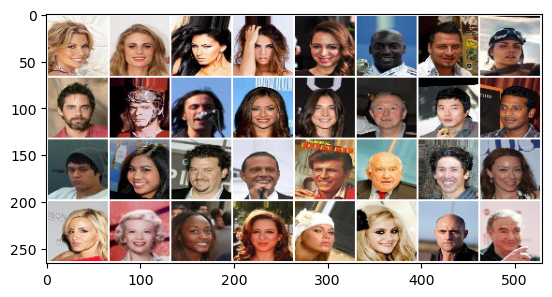



Starting Training Loop...


[epoch=1/30   iter= 100   elapsed_time=   24 secs]     mean_D_loss= 0.2562    mean_G_loss=21.0271
[epoch=1/30   iter= 300   elapsed_time=   58 secs]     mean_D_loss= 0.7281    mean_G_loss= 9.4440
[epoch=2/30   iter= 100   elapsed_time=   87 secs]     mean_D_loss= 0.7063    mean_G_loss= 4.5943
[epoch=2/30   iter= 300   elapsed_time=  125 secs]     mean_D_loss= 0.7870    mean_G_loss= 4.5438
[epoch=3/30   iter= 100   elapsed_time=  157 secs]     mean_D_loss= 0.6686    mean_G_loss= 4.4085
[epoch=3/30   iter= 300   elapsed_time=  197 secs]     mean_D_loss= 0.7281    mean_G_loss= 4.5149
[epoch=4/30   iter= 100   elapsed_time=  230 secs]     mean_D_loss= 0.6891    mean_G_loss= 4.7506
[epoch=4/30   iter= 300   elapsed_time=  269 secs]     mean_D_loss= 0.6342    mean_G_loss= 4.7358
[epoch=5/30   iter= 100   elapsed_time=  302 secs]     mean_D_loss= 0.5143    mean_G_loss= 4.9340
[epoch=5/30   iter= 300   elapsed_time=  341 secs]     mean_D_loss= 0.4951    mean_G_los

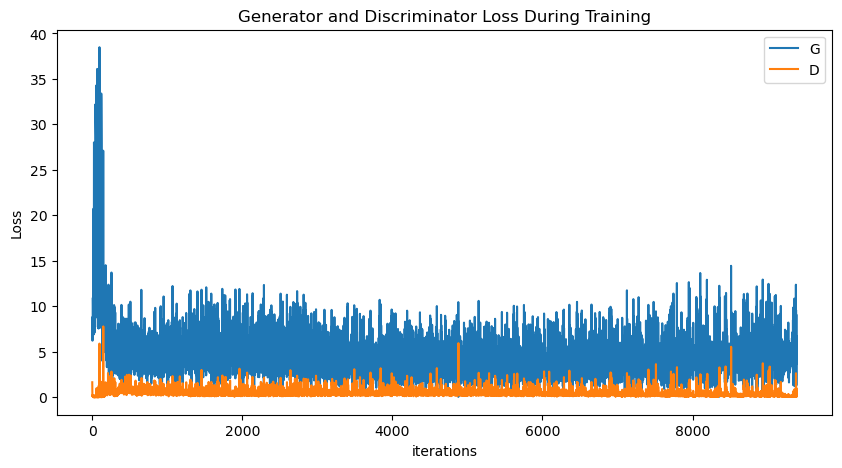

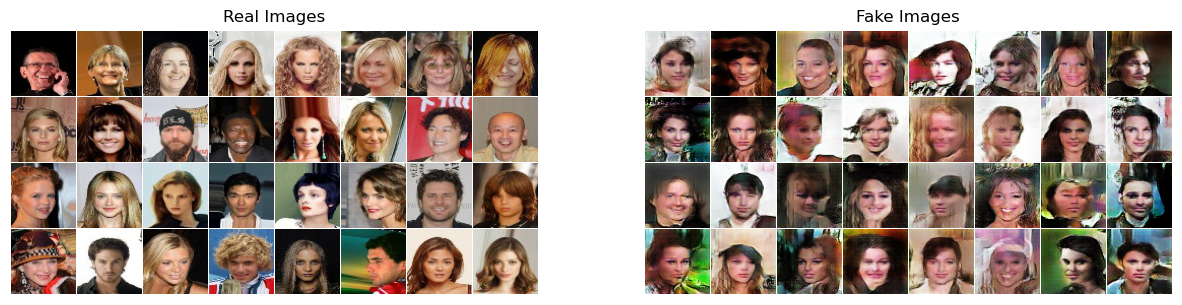

AttributeError: 'MyAdversarialLearning' object has no attribute 'dl_studio'

In [ ]:
# the code below is mainly borrowed from DLSudio-2.5.2


import random
import numpy
import torch
import cv2

seed = 0           
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)


dls = DLStudio(    
                  dataroot = "./Supplementary/celeba_dataset_64x64/",                                                                                    
                  # dataroot = "./dataGAN/PurdueShapes5GAN/multiobj/", 

                  image_size = [64,64],                                                               
                  path_saved_model = "./saved_model",                                                 
                  learning_rate = 2e-4,     ## <== try smaller value if mode collapse
                  epochs = 30,
                  batch_size = 32,                                                                     
                  use_gpu = True,                                                                     
              )           

dcgan = MyAdversarialLearning(
                  dlstudio = dls,
                  ngpu = 1,    
                  latent_vector_size = 100,
                  beta1 = 0.5,                           ## for the Adam optimizer
              )

discriminator =  dcgan.DiscriminatorDG2()
generator =  dcgan.GeneratorDG2()



dcgan.set_dataloader()

dcgan.show_sample_images_from_dataset(dls)

dcgan.run_gan_code(dls, discriminator=discriminator, generator=generator, results_dir="results_DG2")

# save model
torch.save(generator.state_dict(), "./generator.pth")
torch.save(discriminator.state_dict(), "./discriminator.pth")






In [ ]:
# use genertor to generate images and save them for further use
gen = generator.to(dls.device)
gen.eval()
with torch.no_grad():

    # we need 1024 in total, so we need loop 32 times
    for j in range(32):
        noise = torch.randn(32, 100, 1, 1, device=dls.device)    
        fake = gen(noise).detach().cpu() # shape: (32, C, H, W)

        # save them in output dir as png files
        os.makedirs("Generator_Output", exist_ok=True)

        for i in range(fake.size(0)): # 32 in this case
            img = fake[i]  # shape: (C, H, W)
            img = img.numpy().transpose(1, 2, 0)  # to (H, W, C)

            img = (img + 1) / 2.0  # Normalize from [-1,1] → [0,1]
            img = np.clip(img * 255.0, 0, 255)  # Scale to [0,255]
            img = img.astype(np.uint8)

            # Convert from RGB to BGR (OpenCV uses BGR format)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  


            cv2.imwrite(f"Generator_Output/fake_{j*32 + i}.jpg", img)

# 2 Diffusion

### 2.1 Generate Images

Since my personal laptop GPU isn't powerful enough to run multiple epochs of diffusion training with a batch size of 32, I am using the provided weights and skipping the execution of RunCodeForDiffusion.py.

# ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- 

In [ ]:
# the code below is mainly borrowed from DLSudio-2.5.2
import numpy as np


GenerativeDiffusion_dir = os.path.join(DLStudio_dir, "GenerativeDiffusion")
sys.path.append(GenerativeDiffusion_dir)  

from GenerativeDiffusion import *

gauss_diffusion   =  GaussianDiffusion(
                        num_diffusion_timesteps = 1000,
                    )


network =  UNetModel(
                       in_channels=3,
                       model_channels   =  128,
                       out_channels     =  3,
                       num_res_blocks   =  2,
                       attention_resolutions =  (4, 8),               ## for 64x64 images
                       channel_mult     =    (1, 2, 3, 4),            ## for 64x64 images
                       num_heads        =    1,
                       attention        =    True            ## <<< Must be the same as for RunCodeForDiffusion.py
#                       attention        =    False          ## <<< Must be the same as for RunCodeForDiffusion.py

                     )


top_level = GenerativeDiffusion(
                        gen_new_images        =        True,
                        image_size            =        64,
                        num_channels          =        128,
                        ema_rate              =        0.9999,
                        diffusion = gauss_diffusion,
                        network = network,
                        ngpu = 1,
                        path_saved_model = "./RESULTS",
                        clip_denoised=True,
                        num_samples=1024, 
                        batch_size_image_generation=8,
             )   


model_path = "Supplementary/diffusion.pt"


network.load_state_dict( torch.load(model_path) )

network.to(top_level.device)
network.eval()

print("sampling...")
all_images = []

while len(all_images) * top_level.batch_size_image_generation < top_level.num_samples:
    sample = gauss_diffusion.p_sampler_for_image_generation(
        network,
        (top_level.batch_size_image_generation, 3, top_level.image_size, top_level.image_size),
        device = top_level.device,
        clip_denoised = top_level.clip_denoised,
    )
    sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    gathered_samples = [sample]
    all_images.extend([sample.cpu().numpy() for sample in gathered_samples])
    print(f"created {len(all_images) * top_level.batch_size_image_generation} samples")



arr = np.concatenate(all_images, axis=0)
arr = arr[: top_level.num_samples]

shape_str = "x".join([str(x) for x in arr.shape])

out_path = os.path.join("./", f"samples_{shape_str}.npz")

np.savez(out_path, arr)

print("image generation completed")

C:\Users\alanc\AppData\Local\Temp\ipykernel_19436\3717984831.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict( torch.load(model_path) )


sampling...
created 8 samples
created 16 samples
created 24 samples
created 32 samples
created 40 samples
created 48 samples
created 56 samples
created 64 samples
created 72 samples
created 80 samples
created 88 samples
created 96 samples
created 104 samples
created 112 samples
created 120 samples
created 128 samples
created 136 samples
created 144 samples


# ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- DON'T RUN THIS AGAIN ------------- 



Putting together a collage of the generated images for display


For the individual images, check the directory 'visualize_samples'




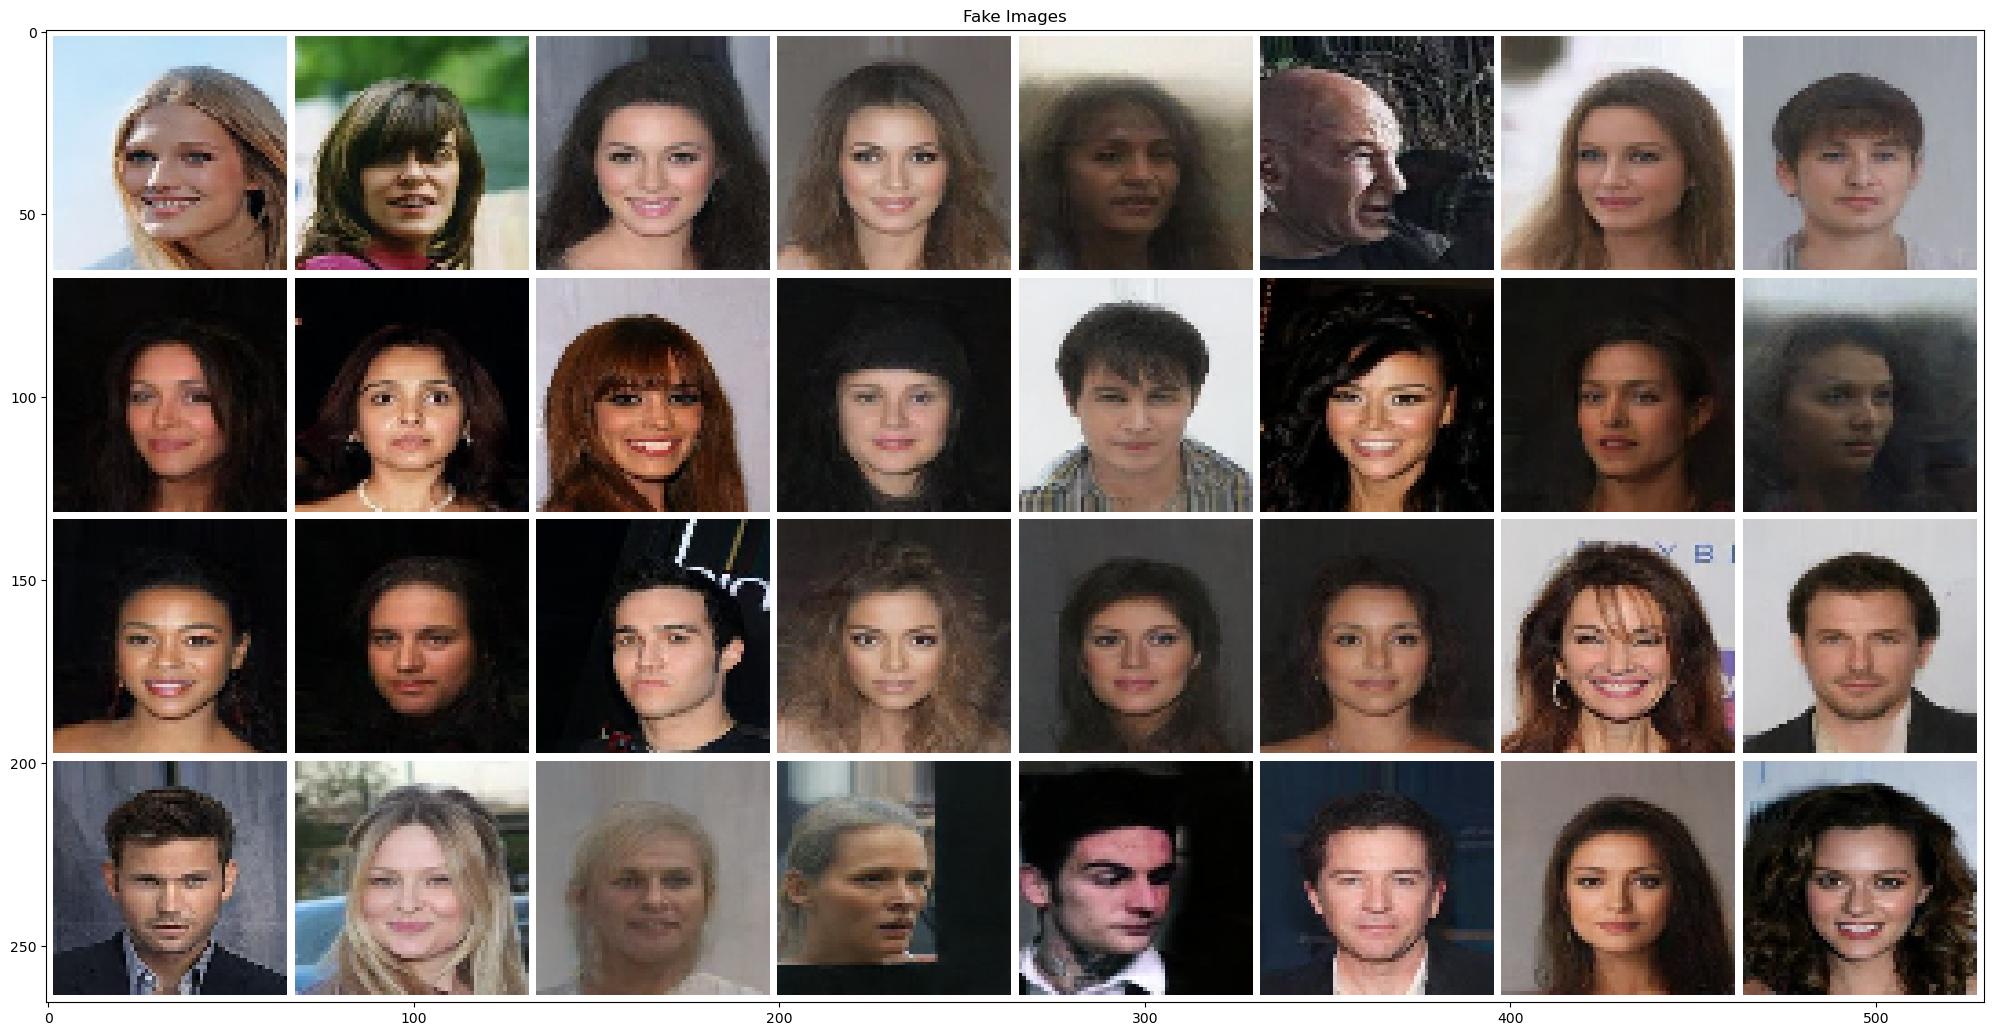

In [ ]:
from PIL import Image

print("\n\nPutting together a collage of the generated images for display\n")
print("\nFor the individual images, check the directory 'visualize_samples'\n\n")


npz_archive = "./samples_32x64x64x3.npz"        ##  You must change this as needed.  The first number, 32,
                                                      ##  is the batch-size used for sampling a checkpoint.  It
                                                      ##  is set in the script GenerateNewImageSamples.py.
                                                      ##
                                                      ##  In our case, an npz archive is a dict with a single 
                                                      ##  'key-value' pair.  The name of the 'key' is 'arr_0'.  
                                                      ##  And the shape of the 'value' will be the shape of the 
                                                      ##  ndarray that stores the generated images. For the example 
                                                      ##  shown, the shape of the value is (32,64,64,3)
visualization_dir  =  "Diffusion_Output"
image_display_size = (256,256)


if os.path.exists(visualization_dir):
    files = glob.glob(visualization_dir + "/*")
    for file in files:
        if os.path.isfile(file):
            os.remove(file)
else:
    os.mkdir(visualization_dir)

data = np.load(npz_archive)

for i, arr in enumerate(data['arr_0']):
    img = Image.fromarray( arr )
    img = img.resize( image_display_size )
    img.save( f"visualize_samples/test_{i}.jpg" )


if os.path.exists(visualization_dir):
    im_tensor_all = torch.from_numpy(data['arr_0']).float()
    im_tensor_all = torch.transpose(im_tensor_all, 1,3)
    im_tensor_all = torch.transpose(im_tensor_all, 2,3)
    plt.figure(figsize=(25,15))   
    plt.imshow( np.transpose( torchvision.utils.make_grid(im_tensor_all, padding=2, pad_value=1, normalize=True).cpu(), (1,2,0) )  )
    plt.title("Fake Images")
    plt.savefig(visualization_dir +  "/fake_images.png")
    plt.show()

# 3 FID score

### 3.1 Display 4x4(16) images generated by GAN

In [ ]:
def display_images(img_dir):
    img_files = os.listdir(img_dir)
    img_files = img_files[:16] # get the first 16 images


    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle("GAN Generated Images")

    for axis, img_file in zip(axes.flatten(), img_files): # axes.flatten() → [ax0, ax1, ..., ax15]. zip → [(ax0, img0), (ax1, img1), ...]
        img_path = os.path.join(img_dir, img_file)
        img = Image.open(img_path)
        axis.imshow(img)
        axis.axis('off')

    plt.tight_layout()
    plt.show()

img_dir = "Generator_Output"
display_images(img_dir)

### 3.2 Display 4x4(16) images generated by Diffusion

In [ ]:
img_dir = "Diffusion_Output"
display_images(img_dir)

### 3.3 GAN FID

In [ ]:
from pytorch_fid.fid_score import calculate_activation_statistics, calculate_frechet_distance
from pytorch_fid.inception import InceptionV3


device = 'cuda' if torch.cuda.is_available() else 'cpu'



def calculate_fid(real_img_dir, fake_img_dir):
    dims = 2048

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device)


    # m1, s1 = calculate_activation_statistics(real_paths, model, device=device)
    # m2, s2 = calculate_activation_statistics(fake_paths, model, device=device)

    # The functions calculate_activation_statistics expect directory paths, not lists of individual image files.
    m1, s1 = calculate_activation_statistics(real_img_dir, model, device=device)
    m2, s2 = calculate_activation_statistics(fake_img_dir, model, device=device)

    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


# you have to write a script to populate the following path lists
# real_paths = ['/real/0.jpg', '/real/1.jpg', ...]
# fake_paths = ['/fake/0.jpg', '/fake/1.jpg', ...]

fake_img_dir = "Generator_Output"
real_img_dir = "Supplementary/celeba_dataset_64x64"

# # make images in the directory as numpy arrays
# fake_img_files = os.listdir(fake_img_dir)
# real_img_files = os.listdir(real_img_dir)

# fake_paths = [os.path.join(fake_img_dir, img_file) for img_file in fake_img_files]
# real_paths = [os.path.join(real_img_dir, img_file) for img_file in real_img_files]

# # calculate FID score
fid_value = calculate_fid(real_img_dir, fake_img_dir)
print(f"FID score of GAN: {fid_value}")


### 3.4 Diffusion FID

In [ ]:
fake_img_dir = "Diffusion_Output"

fid_value = calculate_fid(real_img_dir, fake_img_dir)
print(f"FID score of Diffusion: {fid_value}")

### - Qualitative Evaluation:

For the GAN-generated **(Generator)** images, there is a noticeable lack of detail — textures appear vague and poorly defined. Additionally, the facial proportions are often inconsistent, with some features being unnaturally placed or distorted. However, in my generated dataset, I did not observe signs of mode collapse — the samples appear diverse and vary across different runs.

In contrast, the images generated by the Diffusion model **(p-chain)** are significantly sharper and more realistic. The textures are more consistent and natural-looking, and facial features are generally well-structured and proportionally accurate. Overall, the visual quality of the Diffusion outputs is noticeably higher than that of the GAN.

One reason Diffusion models tend to outperform GANs is due to the fundamental difference in how they are trained and how they generate data. GANs start from Gaussian noise and learn a direct mapping to output images in a single forward pass, which makes training unstable and prone to issues like mode collapse or artifacts. Diffusion models, on the other hand, follow a gradual denoising process: they start with pure noise and iteratively remove noise over many steps to generate a high-quality image. This slow, step-by-step generation allows diffusion models to capture fine-grained details and complex data distributions more effectively.

Architecturally, GANs rely heavily on the adversarial setup between a generator and a discriminator, which often creates a delicate balance that's hard to maintain. Diffusion models, in contrast, are trained with a denoising score matching objective and don’t rely on adversarial loss — making training more stable and less sensitive to hyperparameters. 

### - Quantitative Evaluation:

# Finetune GAN

### 4.1 Training curves

In [ ]:
# the code below is mainly borrowed from DLSudio-2.5.2


import random
import numpy
import torch
import cv2

seed = 0           
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)


dls = DLStudio(    
                  dataroot = "./Diffusion_Output/",                                                                                    
                  image_size = [64,64],                                                               
                  path_saved_model = "./saved_model",                                                 
                  learning_rate = 2e-4,     ## <== try smaller value if mode collapse
                  epochs = 30,
                  batch_size = 32,                                                                     
                  use_gpu = True,                                                                     
              )           

dcgan = MyAdversarialLearning(
                  dlstudio = dls,
                  ngpu = 1,    
                  latent_vector_size = 100,
                  beta1 = 0.5,                           ## for the Adam optimizer
              )

discriminator =  dcgan.DiscriminatorDG2()
discriminator.load_state_dict(torch.load("./discriminator.pth"))
discriminator.to(dls.device)

generator =  dcgan.GeneratorDG2()
generator.load_state_dict(torch.load("./generator.pth"))
generator.to(dls.device)



dcgan.set_dataloader()

dcgan.show_sample_images_from_dataset(dls)

dcgan.run_gan_code(dls, discriminator=discriminator, generator=generator, results_dir="results_DG2_finetuned")

# save model
torch.save(generator.state_dict(), "./generator_finetuned.pth")
torch.save(discriminator.state_dict(), "./discriminator_finetuned.pth")


### 4.2 Visual observations of finetuned GAN against GAN

### 4.3 Visual observations of finetuned GAN against Diffusion

### 4.4 Display 4x4(16) images generated by finetuned GAN

In [ ]:
# use genertor to generate images and save them for further use
gen = generator.to(dls.device)
gen.eval()
with torch.no_grad():
    # we need 1024 in total, so we need loop 32 times
    for j in range(32):
        noise = torch.randn(32, 100, 1, 1, device=dls.device)    
        fake = gen(noise).detach().cpu() # shape: (32, C, H, W)

        # save them in output dir as png files
        os.makedirs("Generator_finetuned_Output", exist_ok=True)

        for i in range(fake.size(0)): # 32 in this case
            img = fake[i]  # shape: (C, H, W)
            img = img.numpy().transpose(1, 2, 0)  # to (H, W, C)

            img = (img + 1) / 2.0  # Normalize from [-1,1] → [0,1]
            img = np.clip(img * 255.0, 0, 255)  # Scale to [0,255]
            img = img.astype(np.uint8)

            # Convert from RGB to BGR (OpenCV uses BGR format)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  


            cv2.imwrite(f"Generator_finetuned_Output/fake_{j*32 + i}.jpg", img)


img_dir = "Generator_finetuned_Output"
display_images(img_dir)

##### - Discuss how training with diffusion-generated images affects the GANs performance.